In [1]:
import bct
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
from igraph import *
import networkx as nx
import scipy.io
import math
import enum
import time
import nx_altair as nxa

## PARAMETERS

In [2]:
node_count = 100 
simulated_graph_count = 100
degree_count = 3

assert degree_count < node_count

In [3]:
def plot_strength_dist(G_list):
    for G in G_list:
        strengths = [G[e[0]][e[1]]['weight'] for e in G.edges()]
        plt.hist(strengths, alpha=0.5)
    plt.ylabel("P(s)")
    plt.xlabel("s")
    plt.title("Strength Distribution")
    plt.show()

def plot_degree_dist(G_list):
    for G in G_list:
        degrees = [G.degree(n) for n in G.nodes()]
        plt.hist(degrees, alpha=0.5)
    plt.ylabel("P(d)")
    plt.xlabel("d")
    plt.title("Degree Distribution")
    plt.show()
    
def VisualizeGraph(G, title):
    pos = nx.spring_layout(G)

    chart = nxa.draw_networkx(
        G=G,
        pos=pos,
        width='weight:N'
    ).properties(title=title, height=500, width=500
    ).interactive()

    return chart

In [4]:
base_scale_free = nx.barabasi_albert_graph(node_count, degree_count, seed=61)
base_k_regular = nx.random_regular_graph(int(base_scale_free.number_of_edges() * 2 / base_scale_free.number_of_nodes()), node_count, seed=61)

print("Scale free network node count: ", base_scale_free.number_of_nodes())
print("K-Regular network node count: ", base_k_regular.number_of_nodes())
print("Scale free network edge count: ", base_scale_free.number_of_edges())
print("K-Regular Watts network edge count: ", base_k_regular.number_of_edges())

G_list = [base_k_regular, base_scale_free]

Scale free network node count:  100
K-Regular network node count:  100
Scale free network edge count:  291
K-Regular Watts network edge count:  250


In [5]:
chart1 = VisualizeGraph(base_scale_free, "Random scale free graph")
chart1

alt.LayerChart(...)

In [6]:
chart2 = VisualizeGraph(base_k_regular, "Random K-Regular graph")
chart2

alt.LayerChart(...)

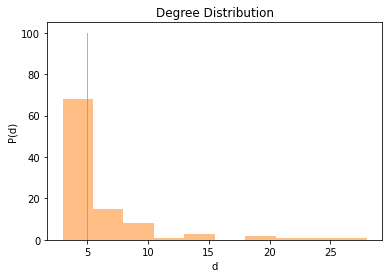

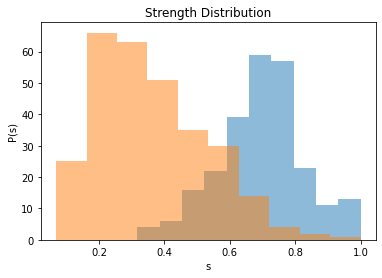

In [7]:
def assignWeightToEdges(G):
    edges_weight = nx.edge_betweenness_centrality(G, normalized=False)
    maximum = max(edges_weight, key=edges_weight.get) 
    #Normalize with max edge weight
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = (edges_weight[e] / edges_weight[maximum])

assignWeightToEdges(base_k_regular)
assignWeightToEdges(base_scale_free)

G_base_list = [base_k_regular, base_scale_free]

plot_degree_dist(G_base_list)
plot_strength_dist(G_base_list)

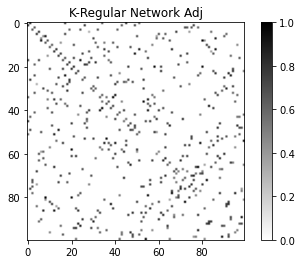

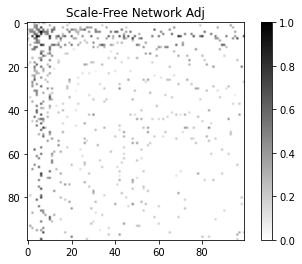

In [8]:
def visuliazeAdj(G, name=""):
    data = nx.to_numpy_array(G)
    plt.imshow(data, cmap="binary")
    plt.colorbar()
    plt.title(name)
    plt.show()

visuliazeAdj(base_k_regular, "K-Regular Network Adj")
visuliazeAdj(base_scale_free, "Scale-Free Network Adj")

In [9]:
def Null_Model(base_graph, count, Verbose=False):
    G_derived_list = []
    for i in range(count):
        a = bct.null_model_und_sign(nx.to_numpy_array(base_graph), seed=61)
        G_derived_list.append(nx.from_numpy_array(a[0]))
        if(True == Verbose):
            clear_output()
            print("%", str(float(i+1) / count * 100))
    return G_derived_list

In [10]:
def getEdges(A):
    edges = []

    vertexCount = A.shape[0]
    for i in range(0, vertexCount):
        for j in range(0, vertexCount):
            if i != j and A[i][j] != 0:
                edges.append([i,j,A[i][j]])
    return edges
        

def BellmanFordAlgo(A, startID):
    
    vertexCount = A.shape[0]
    dist = {} 
    previous = {} 

    for i in range(0, vertexCount):
        dist[i] = float('Inf') 
        previous[i] = None
    dist[startID] = 0 

    edges = getEdges(A)

    changed = True
    relaxationTime = vertexCount-1
    while relaxationTime > 0 and changed: 
        changed = False
        relaxationTime = relaxationTime - 1
        for edge in edges:
             if dist[edge[1]] > dist[edge[0]] + edge[2]:
                 dist[edge[1]]  = dist[edge[0]] + edge[2]
                 previous[edge[1]] = edge[0]
                 changed = True
    #print("It converges after " + str( vertexCount -1 - relaxationTime) + " times.")

    results = []
    for i in range(0, vertexCount):
        results.append([i,dist[i],previous[i]])

    return results

def HarmonicMean(A):
    vertexCount = A.shape[0]
    sum = 0.0

    for i in range(0, vertexCount):
        resultOfBellman = BellmanFordAlgo(A, i)
        for result in resultOfBellman:
            if result[0] != i :
                if result[1] != float('Inf') :
                    if result[1] == 0:
                        print("WARNING: Encountered with 0")
                    else:
                        sum += 1 / result[1]
    
    if sum == 0 :
        #print("WARNING: Harmonic Mean equals to zero")
        return 0

    return (vertexCount* (vertexCount-1)* (1/sum))

def globalEfficiency(adj_matrix):
    h = HarmonicMean(adj_matrix)
    if h == 0 :
        return 0
    return (1/h)

In [11]:
def reciprocalOfEdges(G):
    for e in G.edges():
        G[e[0]][e[1]]['weight'] = (1 / G[e[0]][e[1]]['weight'])

In [12]:
def global_eff(G):
    na = nx.to_numpy_array(G)
    g = Graph.Weighted_Adjacency(na.tolist())
    weights = g.es["weight"][:]
    sp = (1.0 / np.array(g.shortest_paths_dijkstra(weights=weights)))
    np.fill_diagonal(sp,0)
    N=sp.shape[0]
    ne= (1.0/(N-1)) * np.apply_along_axis(sum,0,sp)

    return np.mean(ne)

def Attack_Highest_Weight(base_graph, number_of_attacks, Verbose = False):

    assert number_of_attacks > 1

    G_base_copy = base_graph.copy()
    # 1/w
    reciprocalOfEdges(G_base_copy)

    all_lcc_g_attacked_size = []
    lcc_size = G_base_copy.subgraph(list(max(nx.connected_components(G_base_copy), key=len))).number_of_nodes() 
    lccs0 = lcc_size
    all_lcc_g_attacked_size.append(1)  
    edge_list = sorted(G_base_copy.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
    all_global_efficiency_g_attacked = []
    all_global_efficiency_g_attacked.append(nx.algorithms.efficiency_measures.global_efficiency(G_base_copy))
    
    last_out_time = time.time()
    for i in range(number_of_attacks - 1):
        if(i > base_graph.number_of_edges() - 2): 
            all_lcc_g_attacked_size.append(all_lcc_g_attacked_size[-1]) 
            all_global_efficiency_g_attacked.append(all_global_efficiency_g_attacked[-1]) 
        else:
            # calculate highest_weighted_edge 
            highest_weighted_edge = edge_list[0]
            del edge_list[0]
            # remove highest_weighted_edge from graph
            G_base_copy.remove_edge(highest_weighted_edge[0], highest_weighted_edge[1]) 

            # calculate largest connected component size 
            lcc_size = G_base_copy.subgraph(list(max(nx.connected_components(G_base_copy), key=len))).number_of_nodes()       
            p = 1 - float(abs((lcc_size - lccs0))) / lccs0
            all_lcc_g_attacked_size.append(p)  

            #calculate adj matrix
            #adj_mtr_G_base_copy = nx.to_numpy_array(G_base_copy)  

            #calculate efficiency
            #all_global_efficiency_g_attacked.append(globalEfficiency(adj_mtr_G_base_copy))
            all_global_efficiency_g_attacked.append(global_eff(G_base_copy))
        if(True == Verbose):
            if((time.time() - last_out_time) >= 1 or i+1 >= number_of_attacks - 1):
                clear_output()
                last_out_time = time.time()
                print("%", str(float(i+1) / number_of_attacks * 100))
        
    clear_output()
    print("%100") 
    return all_lcc_g_attacked_size, all_global_efficiency_g_attacked

def Attack_Random(base_graph, number_of_attacks, Verbose = False):
    assert number_of_attacks > 1

    G_base_copy = base_graph.copy()
    reciprocalOfEdges(G_base_copy)

    all_lcc_g_attacked_size = []
    lcc_size = G_base_copy.subgraph(list(max(nx.connected_components(G_base_copy), key=len))).number_of_nodes() 
    lccs0 = lcc_size
    all_lcc_g_attacked_size.append(1)  
    
    all_global_efficiency_g_attacked = []
    all_global_efficiency_g_attacked.append(nx.algorithms.efficiency_measures.global_efficiency(G_base_copy))

    last_out_time = time.time()
    for i in range(number_of_attacks - 1):
        if(i> base_graph.number_of_edges() - 2): 
            all_lcc_g_attacked_size.append(all_lcc_g_attacked_size[-1]) 
            all_global_efficiency_g_attacked.append(all_global_efficiency_g_attacked[-1]) 
        else:
            random_edge = list(G_base_copy.edges())[rnd.randint(0, G_base_copy.number_of_edges() - 1)]
            G_base_copy.remove_edge(random_edge[0], random_edge[1])

            # calculate largest connected component size 
            lcc_size = G_base_copy.subgraph(list(max(nx.connected_components(G_base_copy), key=len))).number_of_nodes()       
            p = 1 - float(abs((lcc_size - lccs0))) / lccs0
            all_lcc_g_attacked_size.append(p)  

            #calculate adj matrix
            #adj_mtr_G_base_copy = nx.to_numpy_array(G_base_copy)  

            #calculate efficiency
            #all_global_efficiency_g_attacked.append(globalEfficiency(adj_mtr_G_base_copy))
            all_global_efficiency_g_attacked.append(global_eff(G_base_copy))
        if(True == Verbose):
            if((time.time() - last_out_time) >= 1 or i+1 >= number_of_attacks - 1):
                clear_output()
                last_out_time = time.time()
                print("%", str(float(i+1) / number_of_attacks * 100))
    
    clear_output()
    print("%100")
    return all_lcc_g_attacked_size, all_global_efficiency_g_attacked

def Save_Numpy(filename, array):
    with open(filename, 'wb') as f:
        np.save(f, array)
    
def Open_Numpy(filename, array):
    with open(filename, 'rb') as f:
        a = np.load(f)
    return a

attack_size = max(base_scale_free.number_of_edges(), base_k_regular.number_of_edges())

In [13]:
tgt_scf_lcc_g_attacked_size, tgt_scf_global_efficiency_g_attacked = Attack_Highest_Weight(base_scale_free, attack_size, True)

%100


In [14]:
tgt_kreg_lcc_g_attacked_size, tgt_kreg_global_efficiency_g_attacked = Attack_Highest_Weight(base_k_regular, attack_size, True)

%100


In [15]:
rnd_scf_lcc_g_attacked_size, rnd_scf_global_efficiency_g_attacked = Attack_Random(base_scale_free, attack_size, True)

%100


In [16]:
rnd_kreg_lcc_g_attacked_size, rnd_kreg_global_efficiency_g_attacked = Attack_Random(base_k_regular, attack_size, True)

%100


In [17]:
def plot_list(list1_to_plot, list2_to_plot, title, x_title, y_title, color1, color2, label1, label2):
    attack_count_list = []
    for i in range(len(list1_to_plot)):
        attack_count_list.append(i)
    p = plt.plot(attack_count_list, list1_to_plot, color=color1, alpha=0.7)
    p = plt.plot(attack_count_list, list2_to_plot, color=color2, alpha=0.7)
    patch1 =  mpatches.Patch(color=color1, label=label1)
    patch2 =  mpatches.Patch(color=color2, label=label2)    
    plt.legend(handles=[patch1, patch2])
    plt.title(title)
    plt.ylabel(y_title)
    plt.xlabel(x_title)
    plt.figure()

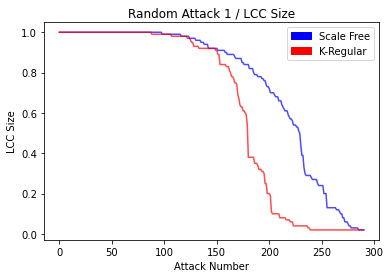

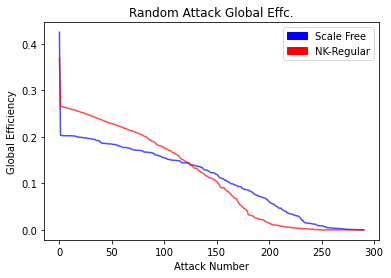

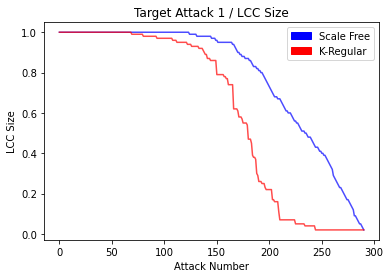

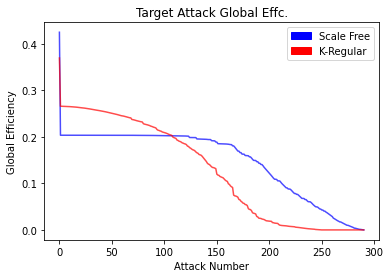

<Figure size 432x288 with 0 Axes>

In [18]:
plot_list(rnd_scf_lcc_g_attacked_size, rnd_kreg_lcc_g_attacked_size, "Random Attack 1 / LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")
plot_list(rnd_scf_global_efficiency_g_attacked, rnd_kreg_global_efficiency_g_attacked, "Random Attack Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "NK-Regular")

plot_list(tgt_scf_lcc_g_attacked_size, tgt_kreg_lcc_g_attacked_size, "Target Attack 1 / LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")
plot_list(tgt_scf_global_efficiency_g_attacked, tgt_kreg_global_efficiency_g_attacked, "Target Attack Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

% 100.0


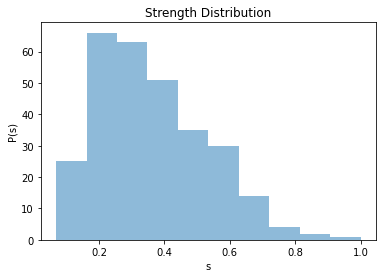

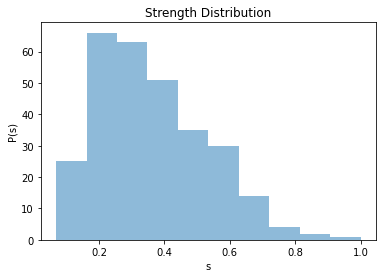

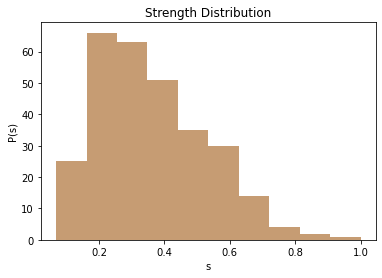

In [19]:
G_List_scf_null_model = Null_Model(base_scale_free, simulated_graph_count, True)
G_List_kreg_null_model = Null_Model(base_k_regular, simulated_graph_count, True)

rand_scf_graph = G_List_scf_null_model[rnd.randint(0, len(G_List_scf_null_model)-1)]
plot_strength_dist([rand_scf_graph])
plot_strength_dist([rand_scf_graph , base_scale_free])

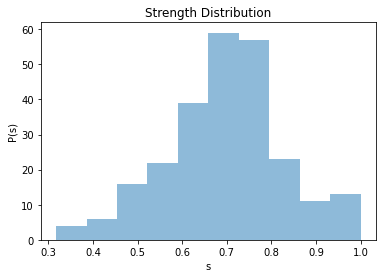

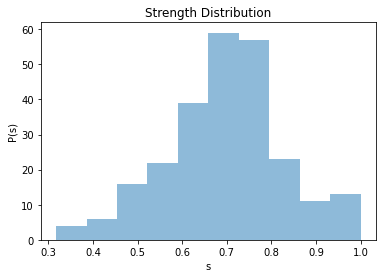

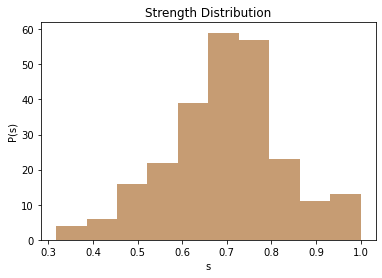

In [20]:
rand_kreg_graph = G_List_kreg_null_model[rnd.randint(0, len(G_List_kreg_null_model)-1)]
plot_strength_dist([rand_kreg_graph])
plot_strength_dist([rand_kreg_graph , base_k_regular])

% 100.0


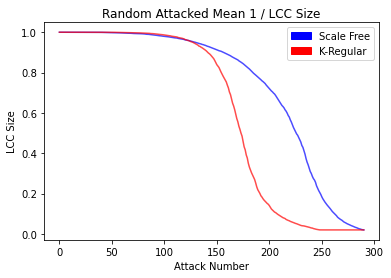

<Figure size 432x288 with 0 Axes>

In [21]:
G_SCF_sim_rand_attack_lcc_results_list = []
G_SCF_sim_rand_attack_gleff_results_list = []
G_SCF_sim_target_attack_lcc_results_list = []
G_SCF_sim_target_attack_gleff_results_list = []

G_KREG_sim_rand_attack_lcc_results_list = []
G_KREG_sim_rand_attack_gleff_results_list = []
G_KREG_sim_target_attack_lcc_results_list = []
G_KREG_sim_target_attack_gleff_results_list = []

last_out_time = time.time()
for i in range(len(G_List_scf_null_model)):
    rnd_lcc_result, rnd_gleff_result = Attack_Random(G_List_scf_null_model[i], attack_size)
    G_SCF_sim_rand_attack_lcc_results_list.append(rnd_lcc_result)
    G_SCF_sim_rand_attack_gleff_results_list.append(rnd_gleff_result)
    
    tgt_lcc_result, tgt_gleff_result = Attack_Highest_Weight(G_List_scf_null_model[i], attack_size)
    G_SCF_sim_target_attack_lcc_results_list.append(tgt_lcc_result)
    G_SCF_sim_target_attack_gleff_results_list.append(tgt_gleff_result)

    rnd_kreg_lcc_result, rnd_kreg_gleff_result = Attack_Random(G_List_kreg_null_model[i], attack_size)
    G_KREG_sim_rand_attack_lcc_results_list.append(rnd_kreg_lcc_result)
    G_KREG_sim_rand_attack_gleff_results_list.append(rnd_kreg_gleff_result)
    
    tgt_kreg_lcc_result, tgt_kreg_gleff_result = Attack_Highest_Weight(G_List_kreg_null_model[i], attack_size)
    G_KREG_sim_target_attack_lcc_results_list.append(tgt_kreg_lcc_result)
    G_KREG_sim_target_attack_gleff_results_list.append(tgt_kreg_gleff_result)

    if((time.time() - last_out_time) >= 1 or i+1 >= len(G_List_scf_null_model)):
        clear_output()
        last_out_time = time.time()
        print("%", str(float(i+1) / len(G_List_scf_null_model) * 100))

def list_mean(list_of_list):
    mean = []
    for i in range(len(list_of_list[0])):
        res = []
        for j in range(len(list_of_list)):
            res.append(list_of_list[j][i])
        mean.append(np.mean(res))
    return mean

SCF_Mean_rnd_lcc = list_mean(G_SCF_sim_rand_attack_lcc_results_list)
SCF_Mean_rnd_gleff = list_mean(G_SCF_sim_rand_attack_gleff_results_list)
SCF_Mean_tgt_lcc = list_mean(G_SCF_sim_target_attack_lcc_results_list)
SCF_Mean_tgt_gleff = list_mean(G_SCF_sim_target_attack_gleff_results_list)

KREG_Mean_rnd_lcc = list_mean(G_KREG_sim_rand_attack_lcc_results_list)
KREG_Mean_rnd_gleff = list_mean(G_KREG_sim_rand_attack_gleff_results_list)
KREG_Mean_tgt_lcc = list_mean(G_KREG_sim_target_attack_lcc_results_list)
KREG_Mean_tgt_gleff = list_mean(G_KREG_sim_target_attack_gleff_results_list)

plot_list(SCF_Mean_rnd_lcc, KREG_Mean_rnd_lcc, "Random Attacked Mean 1 / LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")

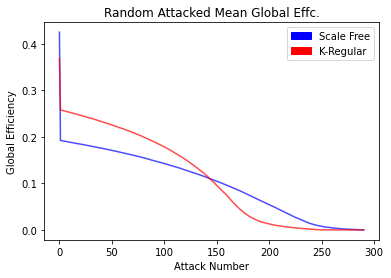

<Figure size 432x288 with 0 Axes>

In [22]:
plot_list(SCF_Mean_rnd_gleff, KREG_Mean_rnd_gleff, "Random Attacked Mean Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

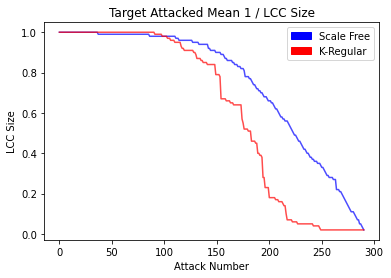

<Figure size 432x288 with 0 Axes>

In [23]:
plot_list(SCF_Mean_tgt_lcc, KREG_Mean_tgt_lcc, "Target Attacked Mean 1 / LCC Size", 'Attack Number', 'LCC Size', 'blue', 'red', 'Scale Free', "K-Regular")

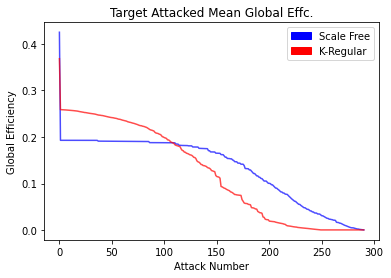

<Figure size 432x288 with 0 Axes>

In [24]:
plot_list(SCF_Mean_tgt_gleff, KREG_Mean_tgt_gleff, "Target Attacked Mean Global Effc.", 'Attack Number', 'Global Efficiency', 'blue', 'red', 'Scale Free', "K-Regular")

In [25]:
Save_Numpy("SCF_Mean_rnd_lcc", np.array(SCF_Mean_rnd_lcc))
Save_Numpy("SCF_Mean_rnd_gleff", np.array(SCF_Mean_rnd_gleff))
Save_Numpy("SCF_Mean_tgt_lcc", np.array(SCF_Mean_tgt_lcc))
Save_Numpy("SCF_Mean_tgt_gleff", np.array(SCF_Mean_tgt_gleff))
Save_Numpy("KREG_Mean_rnd_lcc", np.array(KREG_Mean_rnd_lcc))
Save_Numpy("KREG_Mean_rnd_gleff", np.array(KREG_Mean_rnd_gleff))
Save_Numpy("KREG_Mean_tgt_lcc", np.array(KREG_Mean_tgt_lcc))
Save_Numpy("KREG_Mean_tgt_gleff", np.array(KREG_Mean_tgt_gleff))